## Importing libraries

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, GCNConv, SAGEConv # Graph Neural Network 
from torch_geometric.nn import global_mean_pool 
import rpy2.robjects as robjects # load R object 
from rpy2.robjects import pandas2ri # load R object 
from tqdm import tqdm # print progress bar 
import pickle # save object 
import matplotlib.pyplot as plt
import numpy as np
import random as rd 
import pandas as pd

Load trees and corresponding target parameters and convert them to pandas data.frame

In [5]:
pandas2ri.activate()

#fname_graph = "data/phylogeny-DDD-nt-1e+05-la0-0.5-1.5-mu-0.05-0.5-k-10-20-age-15-ddmod-1-graph.rds"
#fname_param = "data/true-param-DDD-nt-1e+05-la0-0.5-1.5-mu-0.05-0.5-k-10-20-age-15-ddmod-1.rds"

fname_graph = "data_clas/phylogeny-all-graph.rds"
fname_param = "data_clas/true-param-all-graph.rds"

readRDS = robjects.r['readRDS']
df_graph = readRDS(fname_graph)
df_graph = pandas2ri.rpy2py(df_graph)
df_param = readRDS(fname_param)
df_param = pandas2ri.rpy2py(df_param)


#df_param[2] = df_param[2]/100
#df_param[3] = df_param[3]/100

#removing crown age from predictions
#df_param = df_param[0:3]


# Simulating Indices

In [8]:
import random

preselected_sets = True
subset_size = 10000 # Specify the size of the subset
file_of_index = "data/10_3_indices_set_-DDD-Totalset-10000-SubSiz-10000-.rds" # to use the same as R

if preselected_sets == True:
    ind = readRDS(file_of_index) 
    ind = pandas2ri.rpy2py(ind)

    train, valid, test = ind
    train_ind, valid_ind, test_ind = list(train), list(valid), list(test)
    #print(train_ind[1])
    train_ind, valid_ind, test_ind = [i-1 for i in train_ind], [i-1 for i in valid_ind], [i-1 for i in test_ind]
    #print(train_ind[1])

else:
    total_data_points = len(df_graph)
    subset_size = 10000  # Specify the size of the subset

    n_train = int(subset_size * 0.9)
    n_valid = int(subset_size * 0.05)
    n_test = subset_size - n_train - n_valid
    batch_size = min(int(subset_size * 0.01), 10)

    # Pick the phylogenies randomly.
    #true[2] = true[2] / 100
    #true[3] = true[3] / 100
    #ds = convert_encode_to_dataset(cblv, true)

    # Pick the random subset of data points.
    subset_indices = random.sample(range(1, total_data_points), subset_size)

    # Split the subset into train, validation, and test indices.
    train_ind = subset_indices[:n_train]
    valid_ind = subset_indices[n_train:(n_train + n_valid)]
    test_ind = subset_indices[(n_train + n_valid):subset_size]

Checking the total number of trees of the dataset (n_trees) and the number of target parameters for each tree (n_param)

In [4]:
n_param = len(df_param)
n_trees = len(df_graph)

In [3]:
def convert_df_to_tensor(df_node, df_edge, params):

    """
    Convert the data frames containing node and edge information 
    to a torch tensor that can be used to feed neural 
    """

    n_node, n_edge = df_node.shape[0], df_edge.shape[0]
    #n_node, n_edge = int(robjects.r("nrow")(df_node)[0]), int(robjects.r("nrow")(df_edge)[0])

    #pandas_df_node = pd.DataFrame(df_node)
    #pandas_df_edge = pandas2ri.ri2py_dataframe(df_edge)

    l1, l2 = [], []
    
    for i in range(n_edge):
        #print(type(pandas_df_node))
        edge = df_edge.iloc[i]
        u, v = edge[0]-1, edge[1]-1
        l1 = l1 + [u,v]
        l2 = l2 + [v,u]

    edge_index = torch.tensor([l1,l2], dtype=torch.long)

    x = []

    for i in range(n_node):
        node_attr = list(df_node.iloc[i])
        x.append(node_attr)

    x = torch.tensor(x, dtype = torch.float)

    y = torch.tensor(params, dtype = torch.float)

    data = Data(x = x, edge_index = edge_index, y = y)

    return(data)

# Preparing data for training

In [37]:
batch_size_max = 64
data_list  = []

for n in tqdm(range(n_trees)):
    df_node, df_edge = df_graph[n][0], df_graph[n][1]
    params = [df_param[i][n] for i in range(n_param)]
    data = convert_df_to_tensor( pandas2ri.rpy2py(df_node), pandas2ri.rpy2py(df_edge), params)
    data_list.append(data)

#dataloader = DataLoader(data_list, batch_size=batch_size_max)

100%|██████████| 100000/100000 [11:48<00:00, 141.14it/s]


Save or load dataset

In [38]:
fname_param[:-9]

'data/true-param-DDD-nt-1e+05-la0-0.5-1.5-mu-0.05-0.5-k-10-20-age-15-dd'

In [6]:
save = False

fname = fname_param[:-9] + "geomtensor" + ".obj" # file name 
if (save):
    print("Save")
    file = open(fname, "wb") # file handler 
    pickle.dump(data_list, file) # save data_list

else:
    print("Load")
    file = open(fname, "rb")
    data_list = pickle.load(file) 

Load


In [5]:
print("Load")
file = open(fname, "rb")
data_list = pickle.load(file) 

Load


NameError: name 'fname' is not defined

Split dataset into train, valid and test set.

In [9]:
#device = "cuda:2" # GPU to use 
device="cpu"
batch_size_max = 16


train_data = [data_list[i].to(device=device) for i in train_ind]
valid_data = [data_list[i].to(device=device) for i in valid_ind]
test_data  = [data_list[i].to(device=device) for i in test_ind]

train_dl = DataLoader(train_data, batch_size = batch_size_max, shuffle = True)
valid_dl = DataLoader(valid_data, batch_size = batch_size_max, shuffle = True)
test_dl  = DataLoader(test_data , batch_size = 1)

Create the GNN structure

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.conv1 = GCNConv(n_in, n_hidden)
        self.conv2 = GCNConv(n_hidden, n_hidden)
        self.conv3 = GCNConv(n_hidden, n_hidden)
        self.conv4 = GCNConv(n_hidden, n_hidden)
        self.conv5 = GCNConv(n_hidden, 2*n_hidden)
        self.lin1  = torch.nn.Linear(2*n_hidden, n_hidden)
        self.lin2  = torch.nn.Linear(n_hidden, n_out)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

In [11]:
def train(model, batch):
    optimizer.zero_grad()
    out = model(batch)
    batch_size = int(max(data.batch) + 1) # number of trees in the batch 
    loss = F.CrossEntropyLoss(out, data.y.reshape([batch_size, n_out])) # compute loss 
    loss.backward() # backward propagation 
    optimizer.step()
    return(loss)

def valid(model, batch):
    out = model(batch)
    batch_size = int(max(data.batch) + 1) # number of trees in the batch 
    loss = F.CrossEntropyLoss(out, data.y.reshape([batch_size, n_out])) # compute loss
    return(loss)

In [18]:
data_list[1000].num_node_features


6

In [16]:
# Setting up the training 
n_in = data_list[0].num_node_features
n_out = len(data_list[0].y)
n_hidden = 50
n_epochs = 100
model = GCN(n_in, n_hidden, n_out).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = F.CrossEntropyLoss()

In [44]:

valid_list = []
train_list = []


patience = 10  # Number of epochs to wait for improvement
best_loss = float('inf')
best_epoch = 0

early_stop = False
counter = 0



# Training loop 

for epoch in range(n_epochs):
    if early_stop:
        break

    # Training
    model.train()
    train_loss = []
    for data in tqdm(train_dl):
        loss = train(model, data)  # train model and get loss
        loss = float(loss.to(device="cpu"))
        train_loss.append(loss)
    mean_loss = np.mean(train_loss)
    train_list.append(mean_loss)

    print("Epoch %d - Train Loss %.4f" % (epoch, float(mean_loss)))  # print progression

    # Validation
    model.eval()
    valid_loss = []
    for data in tqdm(valid_dl):
        loss = valid(model, data)  # train model and get loss
        loss = float(loss.to(device="cpu"))
        valid_loss.append(loss)
    mean_loss = np.mean(valid_loss)
    valid_list.append(mean_loss)
    print("Epoch %d - Valid Loss %.4f" % (epoch, float(mean_loss)))  # print progression

    # Check for early stopping
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_epoch = epoch
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping at epoch %d" % (epoch))
            early_stop = True

print("Best epoch:", best_epoch)

100%|██████████| 563/563 [00:05<00:00, 94.12it/s] 


Epoch 0 - Train Loss 0.0384


100%|██████████| 32/32 [00:00<00:00, 178.93it/s]


Epoch 0 - Valid Loss 0.0300


100%|██████████| 563/563 [00:04<00:00, 112.77it/s]


Epoch 1 - Train Loss 0.0315


100%|██████████| 32/32 [00:00<00:00, 176.49it/s]


Epoch 1 - Valid Loss 0.0303


100%|██████████| 563/563 [00:05<00:00, 105.87it/s]


Epoch 2 - Train Loss 0.0317


100%|██████████| 32/32 [00:00<00:00, 163.91it/s]


Epoch 2 - Valid Loss 0.0303


100%|██████████| 563/563 [00:06<00:00, 86.82it/s]


Epoch 3 - Train Loss 0.0313


100%|██████████| 32/32 [00:00<00:00, 126.88it/s]


Epoch 3 - Valid Loss 0.0312


100%|██████████| 563/563 [00:06<00:00, 86.09it/s]


Epoch 4 - Train Loss 0.0311


100%|██████████| 32/32 [00:00<00:00, 156.54it/s]


Epoch 4 - Valid Loss 0.0305


100%|██████████| 563/563 [00:06<00:00, 86.57it/s]


Epoch 5 - Train Loss 0.0310


100%|██████████| 32/32 [00:00<00:00, 150.87it/s]


Epoch 5 - Valid Loss 0.0305


100%|██████████| 563/563 [00:06<00:00, 86.65it/s]


Epoch 6 - Train Loss 0.0312


100%|██████████| 32/32 [00:00<00:00, 159.24it/s]


Epoch 6 - Valid Loss 0.0311


100%|██████████| 563/563 [00:05<00:00, 94.64it/s]


Epoch 7 - Train Loss 0.0308


100%|██████████| 32/32 [00:00<00:00, 119.25it/s]


Epoch 7 - Valid Loss 0.0302


100%|██████████| 563/563 [00:06<00:00, 93.04it/s]


Epoch 8 - Train Loss 0.0308


100%|██████████| 32/32 [00:00<00:00, 163.82it/s]


Epoch 8 - Valid Loss 0.0298


100%|██████████| 563/563 [00:06<00:00, 93.05it/s]


Epoch 9 - Train Loss 0.0307


100%|██████████| 32/32 [00:00<00:00, 165.90it/s]


Epoch 9 - Valid Loss 0.0301


100%|██████████| 563/563 [00:05<00:00, 97.11it/s] 


Epoch 10 - Train Loss 0.0306


100%|██████████| 32/32 [00:00<00:00, 159.99it/s]


Epoch 10 - Valid Loss 0.0299


100%|██████████| 563/563 [00:05<00:00, 98.99it/s] 


Epoch 11 - Train Loss 0.0306


100%|██████████| 32/32 [00:00<00:00, 131.68it/s]


Epoch 11 - Valid Loss 0.0302


100%|██████████| 563/563 [00:05<00:00, 101.16it/s]


Epoch 12 - Train Loss 0.0307


100%|██████████| 32/32 [00:00<00:00, 120.03it/s]


Epoch 12 - Valid Loss 0.0300


100%|██████████| 563/563 [00:05<00:00, 95.79it/s]


Epoch 13 - Train Loss 0.0306


100%|██████████| 32/32 [00:00<00:00, 164.74it/s]


Epoch 13 - Valid Loss 0.0305


100%|██████████| 563/563 [00:06<00:00, 91.41it/s]


Epoch 14 - Train Loss 0.0307


100%|██████████| 32/32 [00:00<00:00, 158.48it/s]


Epoch 14 - Valid Loss 0.0305


100%|██████████| 563/563 [00:06<00:00, 87.97it/s]


Epoch 15 - Train Loss 0.0307


100%|██████████| 32/32 [00:00<00:00, 155.30it/s]


Epoch 15 - Valid Loss 0.0303


100%|██████████| 563/563 [00:06<00:00, 86.78it/s]


Epoch 16 - Train Loss 0.0306


100%|██████████| 32/32 [00:00<00:00, 116.11it/s]


Epoch 16 - Valid Loss 0.0297


100%|██████████| 563/563 [00:06<00:00, 85.43it/s]


Epoch 17 - Train Loss 0.0307


100%|██████████| 32/32 [00:00<00:00, 145.41it/s]


Epoch 17 - Valid Loss 0.0307


100%|██████████| 563/563 [00:06<00:00, 84.92it/s]


Epoch 18 - Train Loss 0.0307


100%|██████████| 32/32 [00:00<00:00, 147.57it/s]


Epoch 18 - Valid Loss 0.0303


100%|██████████| 563/563 [00:06<00:00, 86.87it/s]


Epoch 19 - Train Loss 0.0306


100%|██████████| 32/32 [00:00<00:00, 149.09it/s]


Epoch 19 - Valid Loss 0.0296


100%|██████████| 563/563 [00:06<00:00, 88.49it/s]


Epoch 20 - Train Loss 0.0307


100%|██████████| 32/32 [00:00<00:00, 157.01it/s]


Epoch 20 - Valid Loss 0.0303


100%|██████████| 563/563 [00:06<00:00, 85.58it/s]


Epoch 21 - Train Loss 0.0305


100%|██████████| 32/32 [00:00<00:00, 152.16it/s]


Epoch 21 - Valid Loss 0.0301


100%|██████████| 563/563 [00:06<00:00, 92.90it/s]


Epoch 22 - Train Loss 0.0307


100%|██████████| 32/32 [00:00<00:00, 120.74it/s]


Epoch 22 - Valid Loss 0.0304


100%|██████████| 563/563 [00:05<00:00, 96.54it/s]


Epoch 23 - Train Loss 0.0305


100%|██████████| 32/32 [00:00<00:00, 162.49it/s]


Epoch 23 - Valid Loss 0.0309


100%|██████████| 563/563 [00:05<00:00, 100.13it/s]


Epoch 24 - Train Loss 0.0306


100%|██████████| 32/32 [00:00<00:00, 160.77it/s]


Epoch 24 - Valid Loss 0.0300


100%|██████████| 563/563 [00:05<00:00, 97.98it/s] 


Epoch 25 - Train Loss 0.0306


100%|██████████| 32/32 [00:00<00:00, 162.29it/s]


Epoch 25 - Valid Loss 0.0324


100%|██████████| 563/563 [00:05<00:00, 98.56it/s] 


Epoch 26 - Train Loss 0.0306


100%|██████████| 32/32 [00:00<00:00, 124.87it/s]


Epoch 26 - Valid Loss 0.0308


100%|██████████| 563/563 [00:05<00:00, 97.66it/s] 


Epoch 27 - Train Loss 0.0305


100%|██████████| 32/32 [00:00<00:00, 119.87it/s]


Epoch 27 - Valid Loss 0.0301


100%|██████████| 563/563 [00:10<00:00, 54.29it/s]


Epoch 28 - Train Loss 0.0305


100%|██████████| 32/32 [00:00<00:00, 131.31it/s]


Epoch 28 - Valid Loss 0.0297


100%|██████████| 563/563 [00:08<00:00, 70.14it/s]


Epoch 29 - Train Loss 0.0306


100%|██████████| 32/32 [00:00<00:00, 119.98it/s]

Epoch 29 - Valid Loss 0.0298
Early stopping at epoch 29
Best epoch: 19


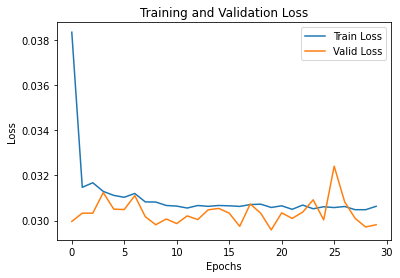

In [45]:
# Plotting the training and validation loss
epochs = range(len(train_list))

plt.plot(epochs, train_list, label='Train Loss')
plt.plot(epochs, valid_list, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
# Specify the file path to save the model
file_path = 'M06_GNN-DDD-10000-k-40-100.pt'

# Save the model
torch.save(model.state_dict(), file_path)

In [18]:
model.load_state_dict(torch.load('M06_GNN-DDD-10000-k-40-100.pt'))

<All keys matched successfully>

In [19]:
#test_dl = DataLoader(data_list[:500], batch_size = 1)
n_param = len(df_param)
pred_list, true_list = [[] for n in range(n_param)], [[] for n in range(n_param)]
model.eval()
for data in test_dl:
    out = model(data.to(device=device))
    pred_params = out.tolist()[0]
    true_params = data.y.tolist()
    for n in range(n_param):
        pred_list[n].append(pred_params[n])
        true_list[n].append(true_params[n])

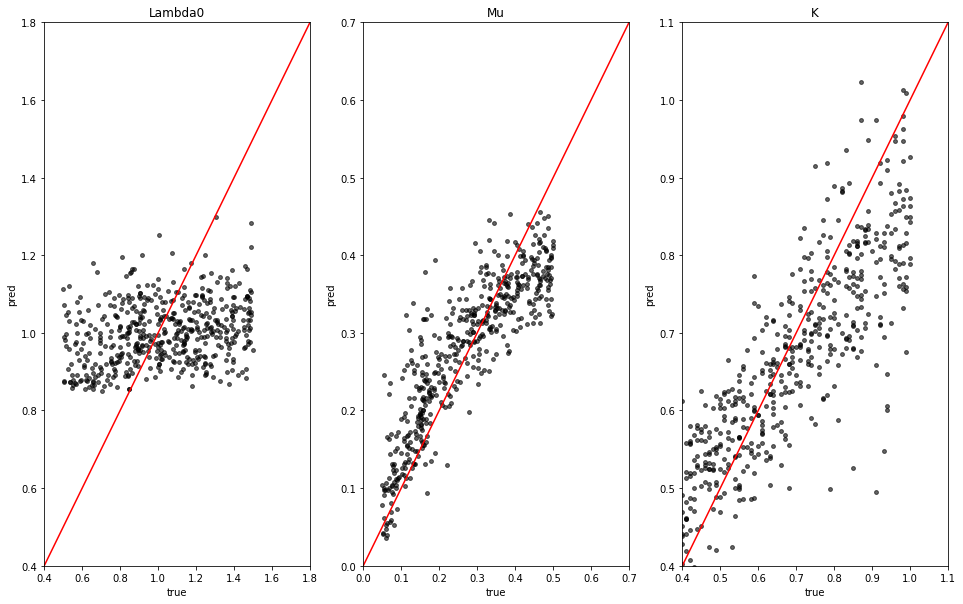

In [24]:
fig, ax = plt.subplots(1,3, figsize = (5*1.62*2,2*5))
lim = [[0.4,1.8],[0.,0.7],[0.40,1.10]]
#title = np.array(df_mle.names)[[0,4]]
preds = [pred_list]
Model = ["GNN ", "MLE "]
param = ["Lambda0", "Mu","K"]

n=0
for m in range(3):
        ax[m].scatter(true_list[m], pred_list[m], s = 15,
                        c = "black", alpha = .6)
        ax[m].plot(np.linspace(lim[m][0], lim[m][1]), np.linspace(lim[m][0], lim[m][1]),
                     c = "red")
        ax[m].set_xlim(lim[m])
        ax[m].set_ylim(lim[m])
        ax[m].set_ylabel("pred")
        ax[m].set_xlabel("true")
        ax[m].set_title(param[m])
        #nrmse = get_nrmse(true_list[n], preds[m][n])
        txt_nrmse = "NRMSE = {nrmse:.3f}"
        #ax[m,n].set_title(Model[m] + title[n] + " | " +  txt_nrmse.format(nrmse = nrmse))

In [51]:
saveRDS = robjects.r['saveRDS']
saveRDS(pred_list, "predGNN_DDD_small.rds")

<rpy2.rinterface_lib.sexp.NULLType object at 0x12e5d4980> [RTYPES.NILSXP]

In [25]:
def get_nrmse(true, pred):

    """ Compute the Normalized Root Mean Square Error of 
    Predictions vs. Truth """
    mse = np.square(np.subtract(true, pred)).mean()
    rmse = np.sqrt(mse)
    nrmse = rmse / np.mean(true)
    return nrmse

for m in range(n_param):
        nrmse = get_nrmse(true_list[m], pred_list[m])
        print(f"NRMSE {param[m]}: {nrmse} ")


NRMSE Lambda0: 0.2575107480829784 
NRMSE Mu: 0.2552377322376925 
NRMSE K: 0.14693749732206138 


### Computing NRMSE by tree Size

In [29]:
phyloname= "data/phylogeny-DDD-nt-1e+05-la0-0.5-1.5-mu-0.05-0.5-k-40-100-age-15-ddmod-1.rds"
phylo = readRDS(phyloname)
df_phylo = pandas2ri.rpy2py(phylo)

node_values = [phylo[i].rx2('Nnode')[0] for i in test_ind]

# Group the indices based on the Nnode values
grouped_indices = {}
for i, node_value in enumerate(node_values):
    if node_value not in grouped_indices:
        grouped_indices[node_value] = []
    grouped_indices[node_value].append(i)

In [30]:
param = ["Lambda0", "Mu","K"]
h = {}
for i, name in enumerate(param):
    h[name] = {}

    # Iterate over each group
    for node_value, indices in grouped_indices.items():
        nrmse_values = []
        # Get the values for the current name and tree indices
        true_values =  [true_list[i][k] for k in indices]
        pred_values = [pred_list[i][k] for k in indices]
        nrmse = get_nrmse(true_values, pred_values)
        nrmse_values.append(nrmse)

        # Store the values in h
        h[name][node_value] = nrmse_values

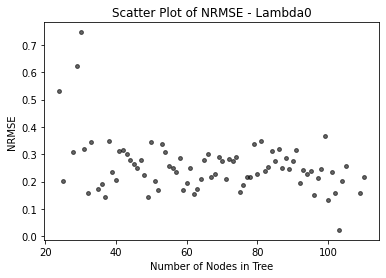

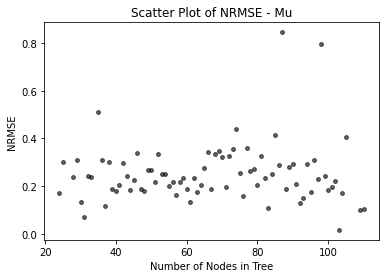

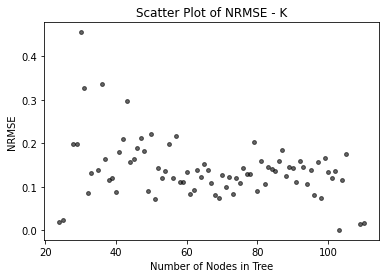

In [32]:
for name, values in h.items():
    # Create a scatter plot
    x = [int(node_value) for node_value in values.keys()]
    y = [value for value in values.values()]
    plt.scatter(x, y,s = 15, c = "black", alpha = .6)
    plt.xlabel('Number of Nodes in Tree')
    plt.ylabel('NRMSE')
    plt.title(f"Scatter Plot of NRMSE - {name}")
    plt.show()